In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import graphviz
from graphviz import Graph

import env
import wrangle_zillow
import os

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# Zillow - Improving Zestimate Logerror

Chloe Whitaker & Lori Ainslie, 01/10/2022

<hr style="border:2px solid gray"> </hr>

# Executive Summary

## Project Goals

* To identify drivers of error in the Zestimate in order to improve accuracy of predicting home values.

## Project Description

* Decreasing the Zestimate error is important because it provides better information to our users and ensures Zillow maintains it's competitive advantage in the marketplace. The model selected will be evaluated by how well it performs over the baseline and previous models.

<hr style="border:2px solid gray"> </hr>

# Acquisition & Preparation

In [2]:
train, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow.prep_zillow()
train.shape, X_train.shape, X_validate.shape, X_test.shape

((28437, 25), (28437, 18), (12188, 18), (10157, 18))

In [3]:
train.head(2)

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,...,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio
0,2.00,4,1352,los_angeles,34273883,-118492869,6925,12447.00,3101,96370,...,357000,6228,0.03,2017-02-27,1,0,0,62,"(60, 70]",0.50
1,3.00,4,1980,los_angeles,34362339,-117653901,8763,21395.00,3101,97324,...,59894,3275,0.15,2017-09-13,1,0,0,36,"(30, 40]",0.75


### Steps taken to prepare the data:

* Pulled data focused on single unit/single family homes from SQL server
* Became familiar with data (column names, data types, # of observations & features, null values, statistical information, and value counts
* Removed columns and rows missing over 50% of their values and columns with information duplicated elsewhere or determined to be unimportant for predicting logerror
* Filled null values of several columns with the mode
* Removed nulls and outliers for other other columns
* Renamed columns for readability and changed data types where it made sense
* Created an age column based on year built and binned the ages
* Created a bed_bath ratio column
* Created dummy variables for columns with object data type
* Used histograms to check out distribution of numerical columns
* Created functions to clean, split, and scale the data

<hr style="border:2px solid gray"> </hr>

# Exploration

<AxesSubplot:>

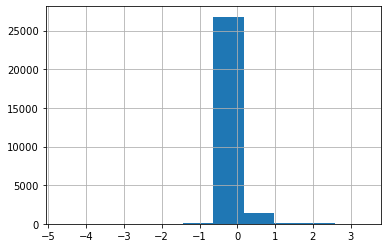

In [4]:
# check distribution of logerror
train.logerror.hist()

## Is there meaningful difference in logerror for each of the counties?

Text(0.5, 1.0, 'Los Angeles Zestimates\n Are Less Likely To Be Accurate')

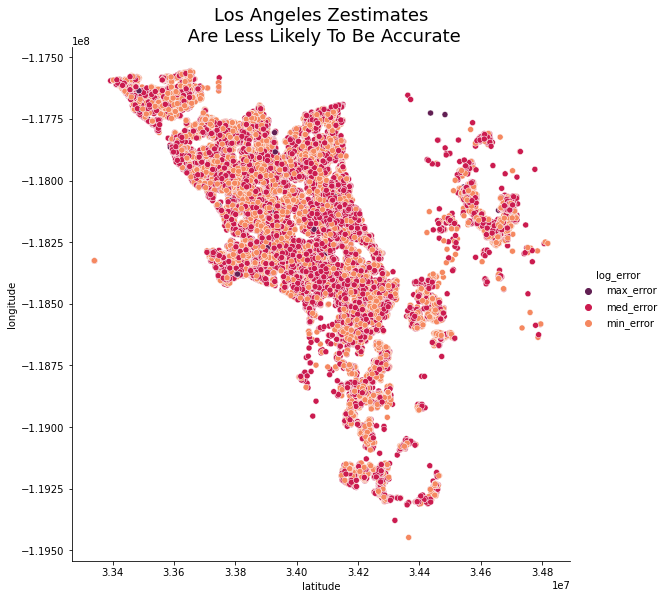

In [5]:
# add a column that bins each value of logerror into max, min, or med absolute error
train['log_error'] = pd.cut(train.logerror, bins=[-5,-1,-.03,.03,1,5], ordered=False, labels=['max_error','med_error','min_error','med_error','max_error'])

# plot the data to see which areas have the most logerror
sns.relplot(data=train, x='latitude', y='longitude', hue='log_error', hue_order=['max_error', 'med_error','min_error'], height=8, palette='rocket')
plt.title('Los Angeles Zestimates\n Are Less Likely To Be Accurate', size=18)

Text(0.5, 1.0, 'Orange County Has The Largest Proportion of Zestimate Max Error,\n Los Angeles Has The Smallest Proportion of Zestimate Minimum Error')

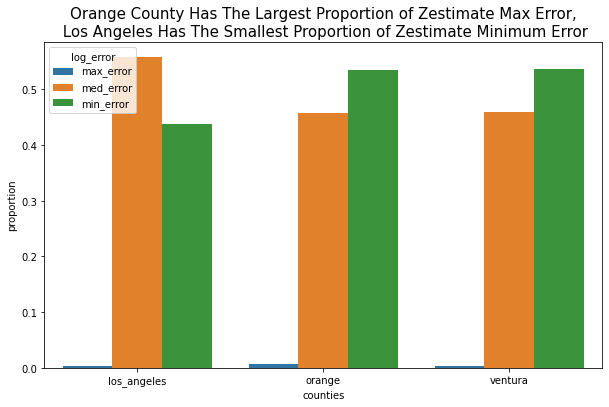

In [6]:
# plot the data to see if any county has a higher percentage of max logerrors
x, y, hue = 'counties', 'proportion', 'log_error'
hue_order = ['max_error', 'med_error', 'min_error']

plt.figure(figsize=(10,6))
(train[hue]
 .groupby(train[x])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
plt.title('Orange County Has The Largest Proportion of Zestimate Max Error,\n Los Angeles Has The Smallest Proportion of Zestimate Minimum Error', size=15)

## Although barely discernible on the chart, it appears the model produces a slightly higher proportion of max error for Orange County but a higher proportion of medium error for Los Angeles County

***

## Could clustering on age & tax-value provide us with useful information?

<AxesSubplot:title={'center':'All Ages - Higher Tax Value,\n Newer - Lower Tax Value,\n Older - Lower Tax Value'}, xlabel='age', ylabel='taxvalue'>

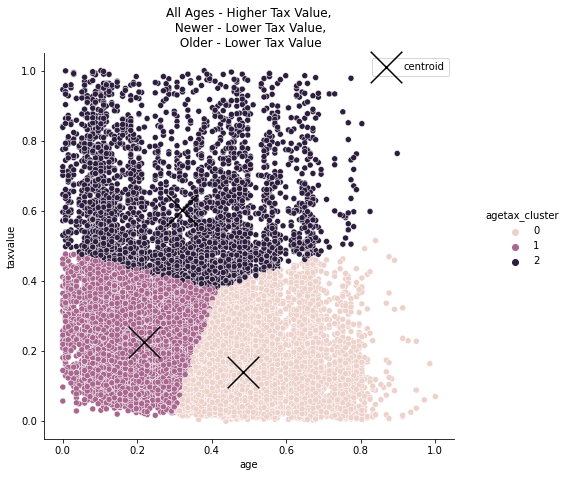

In [7]:
# use a function to create clusters
centroids, X_train, X_validate, X_test = wrangle_zillow.create_agetax_cluster(X_train, X_validate, X_test)

# visualize clustering results
sns.relplot(x = 'age', y ='taxvalue', data = X_train, hue = 'agetax_cluster')
plt.title('All Ages - Higher Tax Value,\n Newer - Lower Tax Value,\n Older - Lower Tax Value', size = 12)

centroids.plot.scatter(x='age', y='taxvalue', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid', figsize=(8, 6))

**- We will conduct statistical testing to see if there is a significant difference in logerror among the clusters**

**- Because of unequal variance, the Kruskal-Wallis test will be used to compare the median logerror among the clusters**

**- The null hypothesis is that there is no significant difference in the median logerror among the clusters**

**- The alternate hypothesis is that there is a significant difference in the median logerror among the clusters**

In [8]:
# combine X_train & y_train into one dataframe
Xy_train = pd.concat([X_train, y_train], axis=1)

# set alpha
alpha = 0.05

# use kruskal-wallis test to compare medians
stat, pvalue = stats.kruskal(
    Xy_train[Xy_train.agetax_cluster == 0].logerror,
    Xy_train[Xy_train.agetax_cluster == 1].logerror,
    Xy_train[Xy_train.agetax_cluster == 2].logerror)

print(f'{stat}, {pvalue}')
if pvalue > alpha:
    print('We fail to reject the null hypothesis')
elif pvalue < alpha:
    print('We reject the null hypothesis')

43.24287152303828, 4.073143941365692e-10
We reject the null hypothesis


## Statistical testing confirms there is a significant difference in logerror for at least two of the clusters and these clusters may be good predictors of logerror

***

## What about clustering on bedrooms, bathrooms, and area?

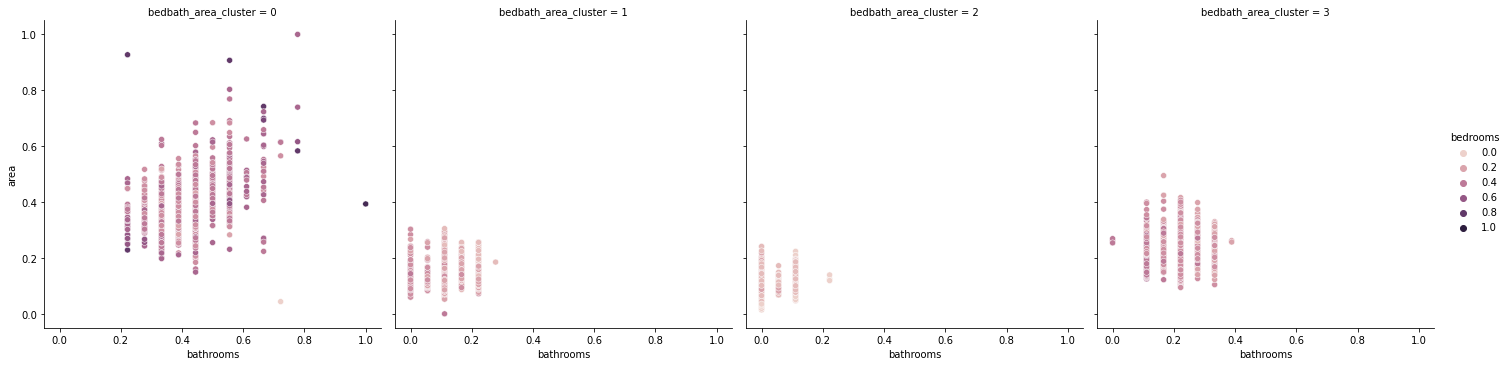

In [9]:
# use a function to create clusters
X_train, X_validate, X_test = wrangle_zillow.create_bedbath_area_cluster(X_train, X_validate, X_test)

# visualize clustering results
sns.relplot(x = 'bathrooms', y ='area', data = X_train, hue = 'bedrooms', col='bedbath_area_cluster')
# plt.title('0 = Large 3+ Bedrooms, 1 = Small 2 Bedrooms, 2 = Tiny 1 Bedroom, 3 = Medium 3 Bedrooms', size=14)

**- We will conduct statistical testing to see if there is a significant difference in logerror among the clusters**

**- Because of unequal variance, the Kruskal-Wallis test will be used to compare the median logerror among the clusters**

**- The null hypothesis is that there is no significant difference in the median logerror among the clusters**

**- The alternate hypothesis is that there is a significant difference in the median logerror among the clusters**

In [10]:
# combine X_train & y_train into one dataframe
Xy_train = pd.concat([X_train, y_train], axis=1)

# set alpha
alpha = 0.05

# use kruskal-wallis test to compare medians
stat, pvalue = stats.kruskal(
    Xy_train[Xy_train.bedbath_area_cluster == 0].logerror,
    Xy_train[Xy_train.bedbath_area_cluster == 1].logerror,
    Xy_train[Xy_train.bedbath_area_cluster == 2].logerror,
    Xy_train[Xy_train.bedbath_area_cluster == 3].logerror)

print(f'{stat}, {pvalue}')
if pvalue > alpha:
    print('We fail to reject the null hypothesis')
elif pvalue < alpha:
    print('We reject the null hypothesis')

198.22533025650696, 1.0200246216781468e-42
We reject the null hypothesis


## Statistical testing confirms there is a significant difference in logerror for at least two of the clusters and these clusters may be good predictors of logerror

***

## Exploration Summary

* The amount of Zestimate error does differ from county to county
* Clustering on tax value and age as well as bedrooms, bathrooms, and area does identify groupings that could be used to predict logerror and these clusters will be used as we move into modeling

<hr style="border:2px solid gray"> </hr>

# Modeling

In [11]:
X_train_model, X_validate_model, X_test_model = wrangle_zillow.prepare_clusters_for_modeling(X_train, X_validate, X_test)

,agetax_cluster_all_ages_hightaxvalue,agetax_cluster_newer_lowtaxvalue,agetax_cluster_older_lowtaxvalue,bedbath_area_cluster_large_3plusbed,bedbath_area_cluster_medium_3bed,bedbath_area_cluster_small_2bed,bedbath_area_cluster_tiny_1bed
0,0,0,1,0,0,1,0
1,0,1,0,0,1,0,0
2,0,1,0,0,0,1,0
3,0,0,1,0,0,1,0
4,0,0,1,0,0,0,1


<hr style="border:2px solid gray"> </hr>

# Conclusion

## Summary

* The goal was to identify drivers of error in the Zestimate in order to improve accuracy of predicting home values.

* We identified some of the drivers of logerror as:
    * ??
    
* We built a model that is expected to perform with an RMSE of about ??? on unseen data.

## Recommendations

## Next Steps

* With more time and resources, we would like to further explore that were created and model each of those separately